## load libraries

In [4]:
# basic operations
import os
import re

import pickle

# data analysis/management/manipulation
import numpy as np
import pandas as pd
# import sklearn

# text analysis
import emoji
import spacy
import en_core_web_lg
import gensim
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity

# data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
## load data
path = '/Users/nicole/Documents/ARP/code/FCAdata'

files = os.listdir(path)

In [3]:
to_concat = [] 

for file in files:
    if file.endswith('_1.csv'):
        print(file)

        #read file
        data = pd.read_csv(f'/Users/nicole/Documents/ARP/code/FCAdata/{str(file)}', lineterminator='\n')

        #select columns 
        data = data[['date', 'month_year', 'tweet', 'brand']]

        to_concat.append(data)

df = pd.concat(to_concat, ignore_index=True)
        


seat_1.csv
mini_1.csv
smart_1.csv
hondae_1.csv
ev_1.csv
renault_1.csv
fiat_1.csv


In [12]:
len(df)

131562

In [13]:
df.brand.value_counts()

ev         60000
renault    29650
hondae     20885
mini       11123
fiat        5819
smart       3817
seat         268
Name: brand, dtype: int64

In [14]:
df.columns

Index(['date', 'month_year', 'tweet', 'brand'], dtype='object')

In [15]:
pd.crosstab(df.brand, df.month_year)

month_year,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06
brand,,,,,,,,,,,,,,,,,,,,,
ev,542,579,663,797,668,738,534,903,992,1133,...,1423,1405,1561,1379,1712,1827,1799,1600,1627,1435
fiat,0,0,0,0,0,0,0,0,0,0,...,115,265,148,308,157,109,133,175,272,213
hondae,0,0,0,0,0,0,0,0,0,0,...,1017,1006,606,530,686,517,779,1034,486,1160
mini,0,0,0,0,0,0,0,0,0,0,...,339,406,408,286,255,285,665,472,237,433
renault,0,0,125,349,213,263,318,302,878,608,...,491,423,405,418,426,276,331,292,305,393
seat,0,0,0,0,0,0,0,0,0,0,...,12,8,10,8,7,9,9,6,5,8
smart,0,0,0,0,0,0,0,0,0,0,...,67,61,85,77,86,58,110,65,131,57


## preprocessing

In [14]:
df.head()

,date,month_year,tweet,brand,clean_tweet
0,2018-11-03,2018-11,Enjoy every minute of city living with the com...,seat,enjoy every minute of city living with the com...
2,2018-11-26,2018-11,Recent move: We took this #SeatMii to a film s...,seat,recent move we took this #seatmii to a film st...
3,2019-01-17,2019-01,What a great start to a Thursday morning! Cong...,seat,what a great start to a thursday morning congr...
4,2019-01-29,2019-01,Someone else had been lucky in an @AutoExpress...,seat,someone else had been lucky in an competition ...
5,2019-01-31,2019-01,We have the new #SEATMii available now with 0%...,seat,we have the new #seatmii available now with 0 ...


In [5]:
punctuation = '!”$%&\’()*+,-./:;<=>?[\\]^_`{|}~•@'

def give_emoji_free_text(tweet): 
    tweet = emoji.get_emoji_regexp().sub(r'', tweet)
    return tweet

def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

# def remove_hashtags(tweet):
#     """Takes a string and removes any hash tags"""
#     tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
#     return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet



In [6]:
def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = give_emoji_free_text(tweet)
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    # tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = tweet.strip() # final strip
    return tweet


def clean_tweets(df):
    """Main function to read in and return cleaned and preprocessed dataframe.
    This can be used in Jupyter notebooks by importing this module and calling the tokenize_tweets() function
    Args:
        df = data frame object to apply cleaning to
    Returns:
        pandas data frame with cleaned tokens
    """

    df['clean_tweet'] = df['tweet'].apply(basic_clean)
    num_tweets = len(df)
    print('Complete. Number of Tweets that have been cleaned and tokenized : {}'.format(num_tweets))
    return df

In [7]:
df= clean_tweets(df)

Complete. Number of Tweets that have been cleaned and tokenized : 131562


In [8]:
# drop duplicates after cleaning
df.drop_duplicates(inplace=True, subset="clean_tweet")

In [9]:
# count the numbers of empty clean_tweet
sum(df['clean_tweet'] == '')

# # drop the row with empty value
# df = df[df['clean_tweet'] != '']

0

In [69]:
# Load spaCy model 'web_lg'
nlp = en_core_web_lg.load()

In [70]:
# # list of abstract
DOCS = [i.strip().lower() for i in df.clean_tweet]

# # # hyphen to underscores
DOCS = [re.sub(r'\b-\b', '_', text) for text in DOCS]

# # # transform Unicode whitespace characters to whitespace
DOCS = [re.sub(r'[\s]+', ' ', text) for text in DOCS]

In [71]:
# Add additional stopwords
stopwords =  ['electric', 'honda', 'toyota', 'vehicle', 'ev', 'electricvehicle', 
'electriccar', 'tesla', 'car', 'evs', 'fiat', 'bmw', '500e', 'hondae', 
'renaultzoe', 'smart', 'eq' , 'renault', 'zoe', 'nissan', 'amp', 'drive', 
'driver', 'mini', 'gt', 'cooper', 'minielectric', 'gm', 'electriccar', 'car', 'vw', 
'electricvehicle', 'drives', 'driving', 'vehicles', 'cars', 'electricvehicles', 'electriccars',
'ford', '', 'hyundai', '£']
 
for stopword in stopwords:
    nlp.vocab[stopword].is_stop = True

In [73]:
nlp.vocab['electriccars'].is_stop

True

In [74]:
# Filter text
DOCS_TOKENS, TMP_TOKENS = [], []

for doc in DOCS:
    TMP_TOKENS = [token.lemma_ for token in nlp(doc)
                  if (token.is_stop == False)
                  and (token.is_punct == False)
                  and (token.like_num == False)] 
    DOCS_TOKENS.append(TMP_TOKENS)

In [75]:
# Check length of docs
length = []
for doc in DOCS:
    length.append(len(doc))

print(np.mean(length))
print(np.std(length))
print(max(length))
print(min(length))

139.20817959546565
68.68658977414196
309
4


In [76]:
# Get rid of common terms
COMMON_TERMS = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in']

# Find phrases
BIGRAM = Phrases(DOCS_TOKENS,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=15000,
                 common_terms=COMMON_TERMS)

TRIGRAM = Phrases(BIGRAM[DOCS_TOKENS],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=15000,
                  common_terms=COMMON_TERMS)

DOCS_PHRASED = [TRIGRAM[BIGRAM[line]] for line in DOCS_TOKENS]

# Check nlp pipeline
print('original:', DOCS[0],
      'Tokenized description:', DOCS_TOKENS[0],
      'Tri-grammed tokenised description:', DOCS_PHRASED[0], sep='\n')

original:
enjoy every minute of city living with the compact #seatmii combining stylish looks frugal fuel consumption and the latest technology it proves that small can be spectacular
Tokenized description:
['enjoy', 'minute', 'city', 'live', 'compact', 'seatmii', 'combine', 'stylish', 'look', 'frugal', 'fuel', 'consumption', 'late', 'technology', 'prove', 'small', 'spectacular']
Tri-grammed tokenised description:
['enjoy', 'minute', 'city', 'live', 'compact', 'seatmii', 'combine', 'stylish', 'look', 'frugal', 'fuel', 'consumption', 'late', 'technology', 'prove', 'small', 'spectacular']


In [77]:
# create dictionary and text corpus
'''
overriding these transformations breaks reproducibility
'''
DICT = Dictionary(DOCS_PHRASED)
CORPUS = [DICT.doc2bow(doc) for doc in DOCS_PHRASED]

In [29]:
# pickle.dump(DOCS_TOKENS, open("/Users/nicole/Documents/ARP/code/DOCS_TOKENS.pkl", "wb"))

## topic modelling

In [78]:
# Change the path with your own
MALLET_PATH = '/Users/nicole/Desktop/CASS/term3/NLP/mallet-2.0.8/bin/mallet'

# define function
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus     : Gensim corpus
    texts      : List of input texts
    limit      : Max number of topics

    Returns:
    --------
    model_list       : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model
                       with respective number of topics
    """
    coherence_values = []
    model_list = []
    mallet_path = MALLET_PATH
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 id2word=dictionary,
                                                 random_seed=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [79]:
# Collect coherence scores as the number of retained topics change
LIMIT, START, STEP = 15, 1, 1
MODEL_LIST, COHER_VALS = compute_coherence_values(dictionary=DICT,
                                                  corpus=CORPUS,
                                                  texts=DOCS_PHRASED,
                                                  start=START,
                                                  limit=LIMIT,
                                                  step=STEP)

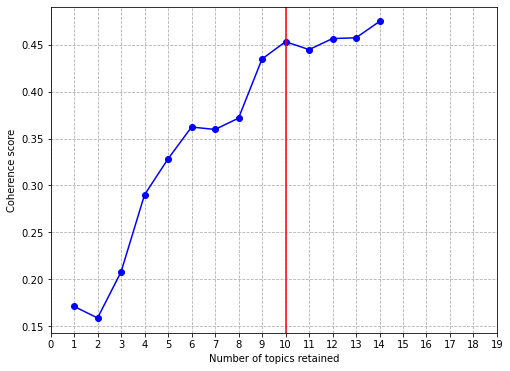

In [81]:
import matplotlib.pyplot as plt

# Plot collected coherence scores data
# data series
X = range(START, LIMIT, STEP)
Y = COHER_VALS

# create figure
FIG = plt.figure(figsize=(8, 6))
AX = FIG.add_subplot(1, 1, 1)

# plot data
AX.plot(X, Y, marker='o', color='b', ls='-')

# axes
AX.set_xlabel("Number of topics retained")
AX.set_ylabel("Coherence score")
AX.set_xticks(np.arange(0,20,1))

# reference line
AX.axvline(x=10, ymin=0, ymax=1, color='r')

# grid
AX.grid(True, ls='--')

plt.show()

In [82]:
N_TOPICS = 10
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)

LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=10)


[(0,
  '0.022*"build" + 0.022*"uk" + 0.019*"start" + 0.016*"truck" + 0.014*"engine" + 0.013*"diesel" + 0.010*"production" + 0.009*"plant" + 0.009*"close" + 0.008*"change"'),
 (1,
  '0.082*"battery" + 0.036*"market" + 0.025*"china" + 0.019*"lithium" + 0.017*"company" + 0.014*"share" + 0.012*"report" + 0.011*"tsla" + 0.011*"demand" + 0.010*"invest"'),
 (2,
  '0.100*"charge" + 0.020*"station" + 0.018*"charger" + 0.016*"fast" + 0.015*"point" + 0.015*"home" + 0.014*"fleet" + 0.014*"india" + 0.012*"infrastructure" + 0.011*"service"'),
 (3,
  '0.030*"energy" + 0.021*"renewable" + 0.019*"mobility" + 0.019*"fuel" + 0.017*"green" + 0.017*"emission" + 0.017*"renewableenergy" + 0.017*"solar" + 0.016*"power" + 0.014*"climatechange"'),
 (4,
  '0.032*"auto" + 0.029*"motor" + 0.026*"future" + 0.025*"automotive" + 0.024*"news" + 0.021*"read" + 0.020*"tech" + 0.020*"plan" + 0.018*"launch" + 0.016*"technology"'),
 (5,
  '0.053*"year" + 0.033*"hybrid" + 0.032*"buy" + 0.027*"video" + 0.025*"price" + 0.021*

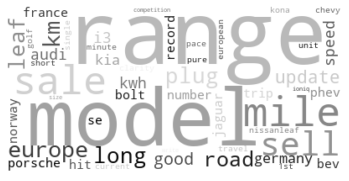

In [83]:
from wordcloud import WordCloud

#Generate topic word clouds
topic = 0 # Initialize counter

NUM_topics = 10

while topic < NUM_topics:
    topic_words_freq = dict(LDA_MALLET.show_topic(topic, topn=50))
    topic += 1    
    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white", colormap='binary').generate_from_frequencies(topic_words_freq) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('general_' + str(topic) + '.png')

In [84]:
# save the result
import pickle
pickle.dump(LDA_MALLET, open("/Users/nicole/Documents/ARP/code/topic_10.pkl", "wb"))

## topic modelling result

In [ ]:
# load the result 

# LDA_MALLET = pickle.load(open("/Users/nicole/Documents/ARP/code/ldamallet_8.pkl", "rb"))

In [86]:
## MDS
# Translate topic modeling outcome
LDA_MALLET_G = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(LDA_MALLET)

# Get transformed corpus as per the LDA model
TRANSF_CORPUS = LDA_MALLET_G.get_document_topics(CORPUS)

# Rearrange data on document-topic pairs probabilities
DOC_TOPIC_M = []

for id, doc in enumerate(TRANSF_CORPUS):
    for topic in np.arange(len(doc)):
        topic_n = doc[topic][0]
        topic_prob = doc[topic][1]
        DOC_TOPIC_M.append([id, topic, topic_prob])

DF = pd.DataFrame(DOC_TOPIC_M)


In [87]:
# rename columns
OLD_NAMES = [0, 1, 2]
NEW_NAMES = ['doc_id', 'topic_n', 'prob']
COLS = dict(zip(OLD_NAMES, NEW_NAMES))
DF.rename(columns=COLS, inplace=True)
DF

,doc_id,topic_n,prob
0,0,0,0.075758
1,0,1,0.075758
2,0,2,0.078042
3,0,3,0.128218
4,0,4,0.096870
...,...,...,...
1124745,112474,5,0.104294
1124746,112474,6,0.151332
1124747,112474,7,0.087415
1124748,112474,8,0.102557


In [88]:
GR = DF.groupby('doc_id')
DF.loc[:, 'max'] = GR['prob'].transform(np.max)
DF.loc[:, 'first_topic'] = 0
DF.loc[DF['prob'] == DF['max'], 'first_topic'] = 1
FIRST_TOPIC = DF.loc[DF['first_topic'] == 1]
FIRST_TOPIC.drop_duplicates('doc_id', keep='first', inplace=True)
FIRST_TOPIC.reset_index(drop=True, inplace=True)
FIRST_TOPIC

ipykernel_launcher:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,doc_id,topic_n,prob,max,first_topic
0,0,8,0.143547,0.143547,1
1,1,6,0.142570,0.142570,1
2,2,7,0.190452,0.190452,1
3,3,9,0.142857,0.142857,1
4,4,7,0.215336,0.215336,1
...,...,...,...,...,...
112470,112470,0,0.152645,0.152645,1
112471,112471,0,0.129630,0.129630,1
112472,112472,9,0.115385,0.115385,1
112473,112473,5,0.153403,0.153403,1


In [89]:
FIRST_TOPIC['topic_n'].value_counts(sort = False)

0     9964
1    10721
2    11560
3    11834
4    11982
5    11322
6    11564
7    11530
8     9709
9    12289
Name: topic_n, dtype: int64

In [90]:
df.reset_index(drop=True, inplace=True)

In [91]:
df1 = pd.concat([df, FIRST_TOPIC], axis=1)

In [94]:
df1[df1['brand'] == 'fiat']['topic_n'].value_counts()

8    1104
5     835
6     740
9     502
7     403
4     359
0     328
2     214
1     163
3     146
Name: topic_n, dtype: int64

## sementic axis

In [96]:
from scipy import spatial
inquire = pd.read_excel("inquireraugmented.xls",
                        usecols=['Entry', 'Positiv', 'Negativ'])
inquire.drop(index=0, inplace=True)
inquire.reset_index(drop=True, inplace=True)

In [97]:
# custom function that creates a semantic axis from a sample
# of words coming from the General Inquirer
pos_ = inquire.loc[inquire["Positiv"].notnull(), "Entry"].to_list()
neg_ = inquire.loc[inquire["Negativ"].notnull(), "Entry"].to_list()

In [98]:
# get the affect score for a sample of unseen words
def semantic_ax(word_list, vector_len=300):
    wv = {}
    # step 2, get the word vectors
    for word in word_list:
        wv[word] = nlp.vocab[word].vector
    # step 3, get the centroid of each pole
    centroid = []
    for i in range(vector_len):
        dimension = [wv[word][i] for word in wv.keys()]
        centroid.extend([np.mean(dimension)])
    # return data
    return wv, np.array(centroid)


pos_wv, pos_centroid = semantic_ax(pos_)
neg_wv, neg_centroid = semantic_ax(neg_)

In [99]:
# step 4, get the semantic axis
my_ax_1 = pos_centroid - neg_centroid

In [100]:
all_words = []
for word in DOCS_TOKENS:
    for i in word:
        all_words.append(i)

all_words = list(set(all_words))

In [101]:
len(all_words)

69728

In [103]:
# supoort & non-support (Affil & Hostile)
all_pos = []
for word in all_words:
    if nlp.vocab[word].vector is not None:
        pos = 1 - spatial.distance.cosine(my_ax_1, nlp.vocab[word].vector)
        all_pos.append(pos)

dict_1 = pd.DataFrame({'words':all_words, 'pos':all_pos})
dict_1.dropna(inplace=True)
dict_1.reset_index(inplace=True)
dict_1.drop(columns=['index'], inplace=True)
dict_1

/opt/anaconda3/envs/FCA3-env/lib/python3.6/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,words,pos
0,foglights,-0.118943
1,mucky,-0.147185
2,tarnish,-0.119557
3,maclean,-0.142717
4,alcohol,-0.068086
...,...,...
30622,rainy,-0.046298
30623,perso,0.010697
30624,europe,0.025493
30625,track,0.111722


In [104]:
# assign sentiment class (support or non support)
dict_1 = dict_1.assign(classification=[1 if x >0 else -1 for x in dict_1['pos']])

In [105]:
pickle.dump(dict_1, open('/Users/nicole/Documents/ARP/code/dict_1.pkl', 'wb'))

In [107]:
df2 = df1[['date', 'month_year', 'tweet', 'brand', 'clean_tweet', 'topic_n', 'prob']]

In [108]:
df2['token'] = DOCS_TOKENS

ipykernel_launcher:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [109]:
df2.head()

,date,month_year,tweet,brand,clean_tweet,topic_n,prob,token
0,2018-11-03,2018-11,Enjoy every minute of city living with the com...,seat,enjoy every minute of city living with the com...,8,0.143547,"[enjoy, minute, city, live, compact, seatmii, ..."
1,2018-11-26,2018-11,Recent move: We took this #SeatMii to a film s...,seat,recent move we took this #seatmii to a film st...,6,0.142570,"[recent, take, seatmii, film, studio, good, ca..."
2,2019-01-17,2019-01,What a great start to a Thursday morning! Cong...,seat,what a great start to a thursday morning congr...,7,0.190452,"[great, start, thursday, morning, congratulati..."
3,2019-01-29,2019-01,Someone else had been lucky in an @AutoExpress...,seat,someone else had been lucky in an competition ...,9,0.142857,"[lucky, competition, seatuk, seat, mii, seatmi..."
4,2019-01-31,2019-01,We have the new #SEATMii available now with 0%...,seat,we have the new #seatmii available now with 0 ...,7,0.215336,"[new, seatmii, available, apr, representative,..."


In [110]:
# pickle.dump(df2, open("/Users/nicole/Documents/ARP/code/df2.pkl", "wb"))

In [9]:
# df2 = pickle.load(open("/Users/nicole/Documents/ARP/code/df2.pkl", "rb"))
# dict_1 = pickle.load(open("/Users/nicole/Documents/ARP/code/dict_1.pkl", "rb"))

In [111]:
# define a function for calculating comments' scores
def get_score(dict_, df_):
    score = []
    for word in df_['token']:
        line_score = []
        for w in word:
            if w in list(dict_['words']):
                pos = dict_[dict_['words'] == w]['pos']
                line_score.append(pos)
        score.append(np.mean(line_score))
    df_['score'] = score

In [112]:
# define a function to get sentiment class

def get_class(dict_, df_):
    score = []
    for word in df_['token']:
        line_score = []
        for w in word:
            if w in list(dict_['words']):
                pos = dict_[dict_['words'] == w]['classification']
                line_score.append(pos)
        score.append(np.sum(line_score))
    df_['class'] = score

In [113]:
df3 = []

for i in list(df2['brand'].unique()):
    print(i)
    df_tmp = df2[df2['brand'] == i]
    get_score(dict_1, df_tmp)
    df3.append(df_tmp)

seat


ipykernel_launcher:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


mini


/opt/anaconda3/envs/FCA3-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/FCA3-env/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


smart
hondae
ev
renault
fiat


In [114]:
df_score = pd.concat(df3)


In [115]:
get_class(dict_1, df_score)

In [116]:
df_score.head()

,date,month_year,tweet,brand,clean_tweet,topic_n,prob,token,score,class
0,2018-11-03,2018-11,Enjoy every minute of city living with the com...,seat,enjoy every minute of city living with the com...,8,0.143547,"[enjoy, minute, city, live, compact, seatmii, ...",0.145963,16.0
1,2018-11-26,2018-11,Recent move: We took this #SeatMii to a film s...,seat,recent move we took this #seatmii to a film st...,6,0.142570,"[recent, take, seatmii, film, studio, good, ca...",0.133016,6.0
2,2019-01-17,2019-01,What a great start to a Thursday morning! Cong...,seat,what a great start to a thursday morning congr...,7,0.190452,"[great, start, thursday, morning, congratulati...",0.071265,7.0
3,2019-01-29,2019-01,Someone else had been lucky in an @AutoExpress...,seat,someone else had been lucky in an competition ...,9,0.142857,"[lucky, competition, seatuk, seat, mii, seatmi...",0.059722,5.0
4,2019-01-31,2019-01,We have the new #SEATMii available now with 0%...,seat,we have the new #seatmii available now with 0 ...,7,0.215336,"[new, seatmii, available, apr, representative,...",0.139158,15.0


In [118]:

df_score['class_'] = np.where(df_score['class']>0, 'positive', 'negative')

In [119]:
pickle.dump(df_score, open("/Users/nicole/Documents/ARP/code/df_score.pkl", "wb"))

In [192]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df_score= pickle.load(open("/Users/nicole/Documents/ARP/code/df_score.pkl", "rb"))

### topics with most negative sentiment

In [214]:
df

In [282]:
def plot_neg(brand):

    tmp = df[df['brand'] == brand].set_index('date').groupby(['topic','class_'])['tweet'].resample('QS').count().unstack()

    tmp_divide = tmp.divide(tmp.groupby(level = 0).sum())

    fig,ax = plt.subplots(figsize = (10,6))

    tmp_divide.xs('negative', level = 1).transpose().plot(kind='bar', ax = ax)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticklabels(['2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2'], rotation = 60)
    plt.legend (loc = 'upper right', bbox_to_anchor=(1.4, 1))
    plt.title('topic associated with negative sentiment - ' + brand)


,date,month_year,tweet,brand,clean_tweet,topic_n,prob,token,score,class,class_,topic
0,2019-01-17,2019-01,What a great start to a Thursday morning! Cong...,seat,what a great start to a thursday morning congr...,7,0.190452,"[great, start, thursday, morning, congratulati...",0.071265,7.0,positive,Noise
1,2019-01-29,2019-01,Someone else had been lucky in an @AutoExpress...,seat,someone else had been lucky in an competition ...,9,0.142857,"[lucky, competition, seatuk, seat, mii, seatmi...",0.059722,5.0,positive,Mile Range
2,2019-01-31,2019-01,We have the new #SEATMii available now with 0%...,seat,we have the new #seatmii available now with 0 ...,7,0.215336,"[new, seatmii, available, apr, representative,...",0.139158,15.0,positive,Noise
3,2019-02-22,2019-02,@SEATItalia @SEATofficial #seatmii #frline my ...,seat,#seatmii #frline my baby ♡,7,0.145083,"[seatmii, frline, baby, ♡]",0.016547,0.0,negative,Noise
4,2019-03-06,2019-03,Still searching for that perfect #firstcar? Wi...,seat,still searching for that perfect #firstcar wit...,7,0.211444,"[search, perfect, firstcar, ideal, mix, style,...",0.204137,16.0,positive,Noise
...,...,...,...,...,...,...,...,...,...,...,...,...
71642,2021-06-29,2021-06,✅ Music that sounds like a duck in pain ✅ Quic...,fiat,music that sounds like a duck in pain quick ed...,0,0.152645,"[music, sound, like, duck, pain, quick, edit, ...",0.052495,7.0,positive,Car Manufactruing
71643,2021-06-30,2021-06,2017 FIAT 500e * Sunroof * Warranty * We Expor...,fiat,2017 fiat 500e sunroof warranty we export ebay,0,0.129630,"[sunroof, warranty, export, ebay]",0.037062,2.0,positive,Car Manufactruing
71644,2021-06-30,2021-06,@TeslaStars @AG60037512 @IdiotsInVehicle @karp...,fiat,eqa has it fiat 500e does too i think q4 has it,9,0.115385,"[eqa, think, q4]",-0.087472,-2.0,negative,Mile Range
71645,2021-06-30,2021-06,"@WholeMarsBlog @elonmusk I have a question, I ...",fiat,i have a question i don't own a tesla yet i ha...,5,0.153403,"[question, start, wonder, detach, charger, tak...",0.016087,1.0,positive,Expense Related


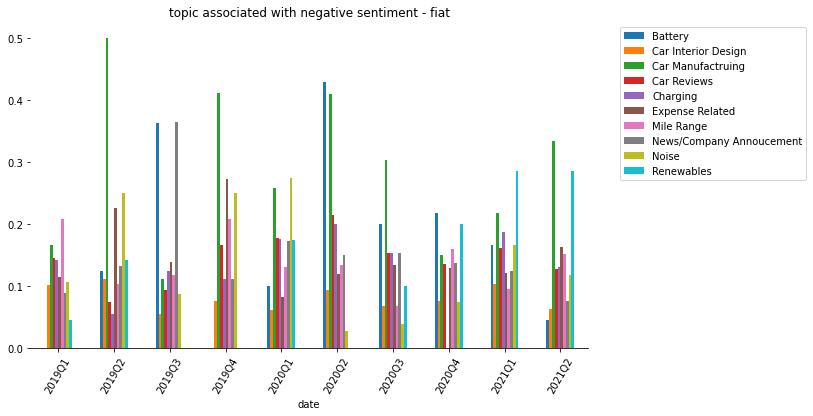

In [300]:
plot_neg('ev')

### neg pos composition

In [132]:
test = df_score[df_score['brand'] == 'fiat']

test['class_'] = np.where(test['class']>0, 'positive', 'negative')

ipykernel_launcher:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [133]:
tmp3 = test.groupby('month_year')['class_'].value_counts().unstack(fill_value = 0)

tmp3['total'] = tmp3['positive'] + tmp3['negative']

tmp3['neg_per'] = np.true_divide(tmp3['negative'], tmp3['total']) * 100
tmp3['pos_per'] = np.true_divide(tmp3['positive'], tmp3['total']) * 100

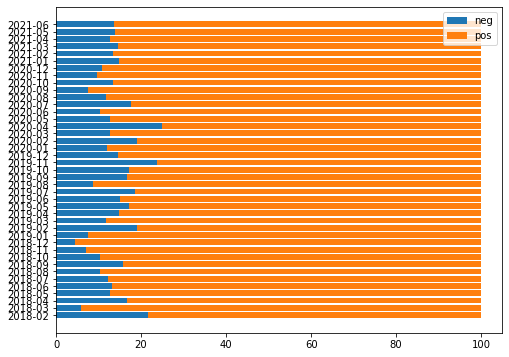

In [134]:
fields = ['neg_per', 'pos_per']
labels = ['neg', 'pos']

fig, ax = plt.subplots(figsize = (8,6))

left = len(tmp3) * [0]
for idx, name in enumerate(fields):
    plt.barh(tmp3.index, tmp3[name], left = left, label = labels)
    left = left + tmp3[name]

plt.legend(labels, loc = 'best')

### topic composition

In [142]:
## taking only data starting from 2019

df = df_score[df_score['date'] >= '2019-01-01']

In [143]:
topic_df = pd.DataFrame({
    "topic_n" : range(0, 10),
    'topic': np.nan
})

topic_df.loc[0, 'topic'] = 'Car Manufactruing'
topic_df.loc[1, 'topic'] = 'Battery'
topic_df.loc[2, 'topic'] = 'Charging'
topic_df.loc[3, 'topic'] = 'Renewables'
topic_df.loc[4, 'topic'] = 'News/Company Annoucement'
topic_df.loc[5, 'topic'] = 'Expense Related'
topic_df.loc[6, 'topic'] = 'Car Reviews'
topic_df.loc[7, 'topic'] = 'Noise'
topic_df.loc[8, 'topic'] = 'Car Interior Design'
topic_df.loc[9, 'topic'] = 'Mile Range'

topic_df

,topic_n,topic
0,0,Car Manufactruing
1,1,Battery
2,2,Charging
3,3,Renewables
4,4,News/Company Annoucement
5,5,Expense Related
6,6,Car Reviews
7,7,Noise
8,8,Car Interior Design
9,9,Mile Range


In [144]:
df = pd.merge(df, topic_df, how = 'left', on = 'topic_n')

In [161]:
def topic_plot(brand):
    tmp1 = df[df['brand'] == brand].groupby(['topic', 'month_year'])['tweet'].count().reset_index()

    tmp1 = tmp1.sort_values(by = ['month_year', 'topic'])

    tmp1['cumsum'] = tmp1['tweet'].cumsum()

    tmp2 = pd.pivot_table(tmp1, values = 'tweet', index = ['month_year'], columns = ['topic'], aggfunc = np.sum, fill_value=0)
    # get % 
    tmp2_divide = tmp2.divide(tmp2.sum(axis = 1), axis = 0)

    fields = tmp2.columns.tolist()
    labels = tmp2.columns.tolist()

    # figure 1
    fig, (ax1, ax2)= plt.subplots(2, figsize=(12, 10))

    bottom = len(tmp2) * [0]
    for idx, topic in enumerate(fields):
        ax1.bar(tmp2.index, tmp2[topic], bottom = bottom, label = labels)
        bottom = bottom + tmp2[topic]

    # remove spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax1.set_xticklabels([])
    ax1.set_ylabel('Tweet Count')

    # figure 2 
    tmp2_divide.plot(kind = 'area', stacked = True, ax = ax2)

    # remove spines
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    ax2.legend(loc = 'best', bbox_to_anchor=(1.4, 2), frameon = False)
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Topic composition %')

    ax1.set_title('Topic Composition - ' + brand)



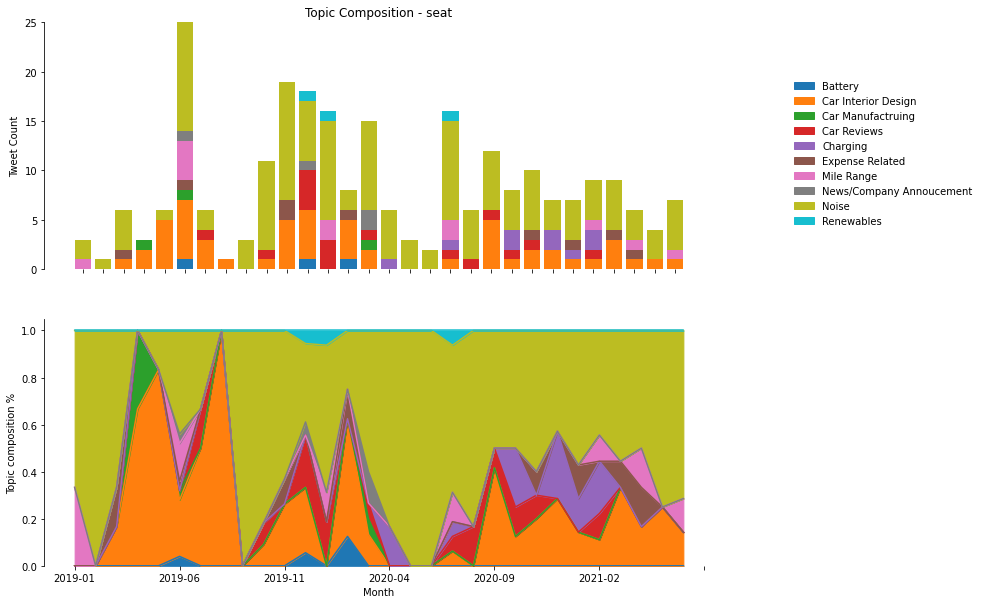

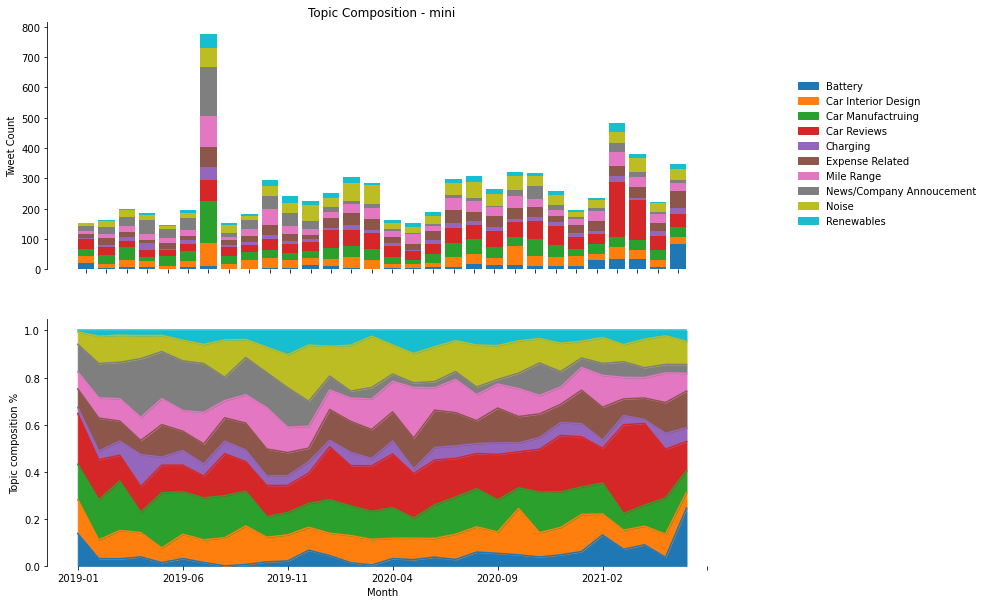

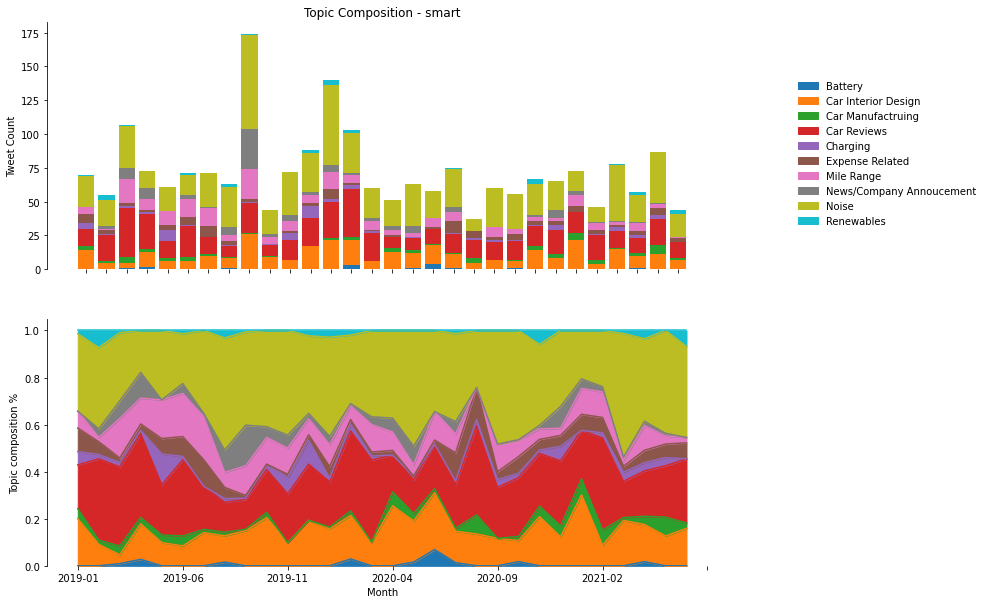

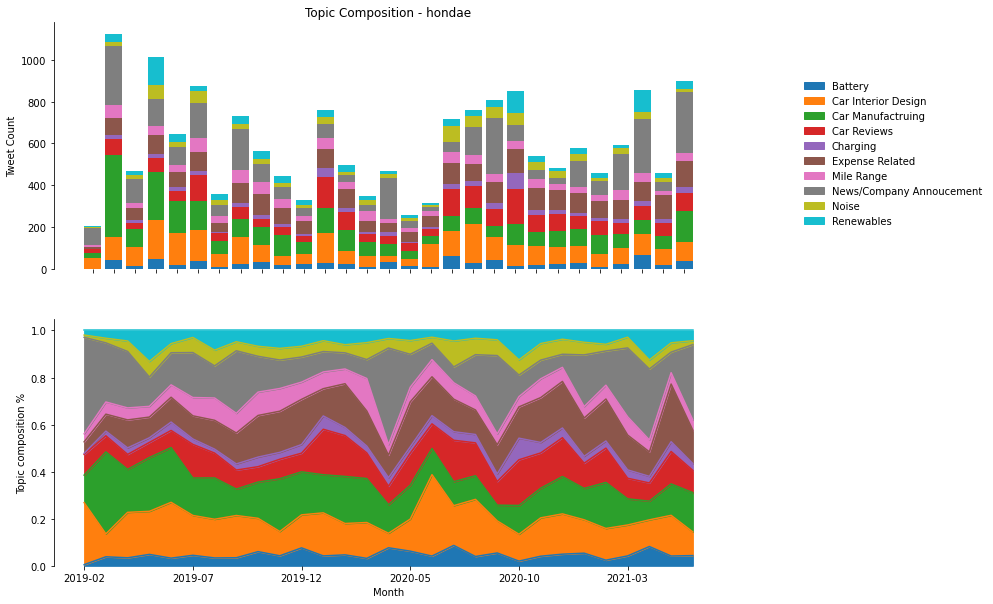

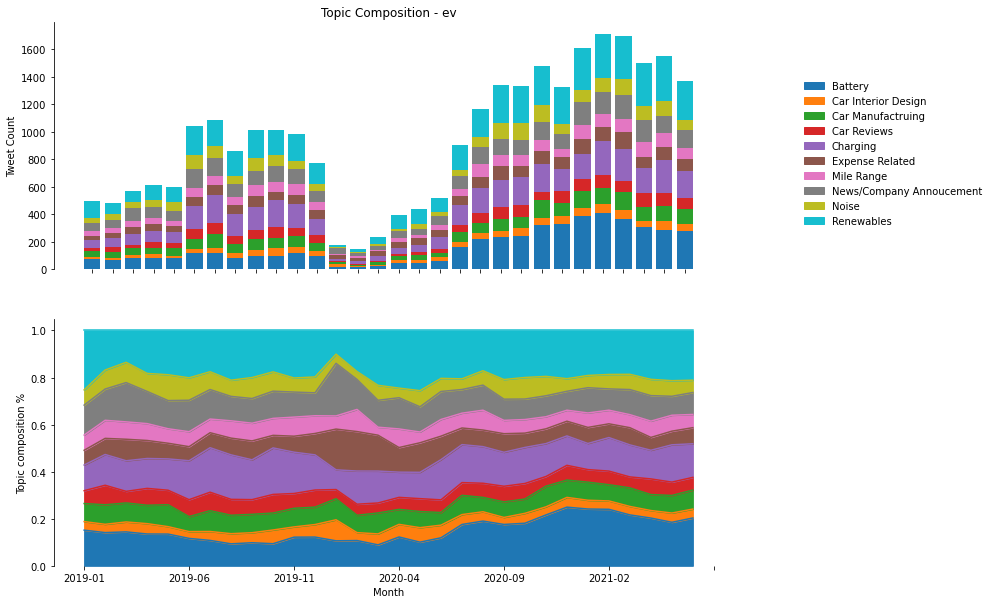

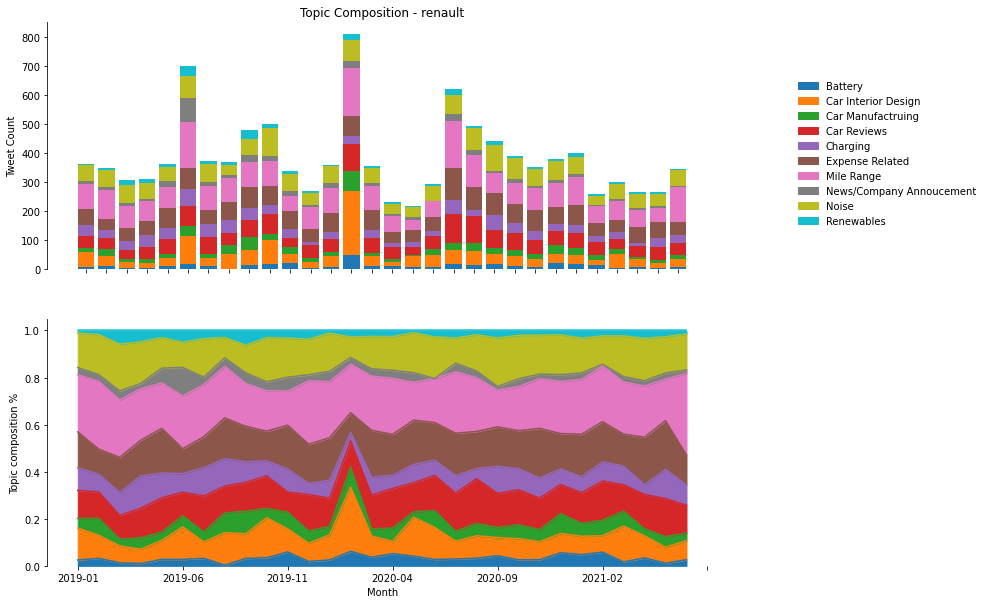

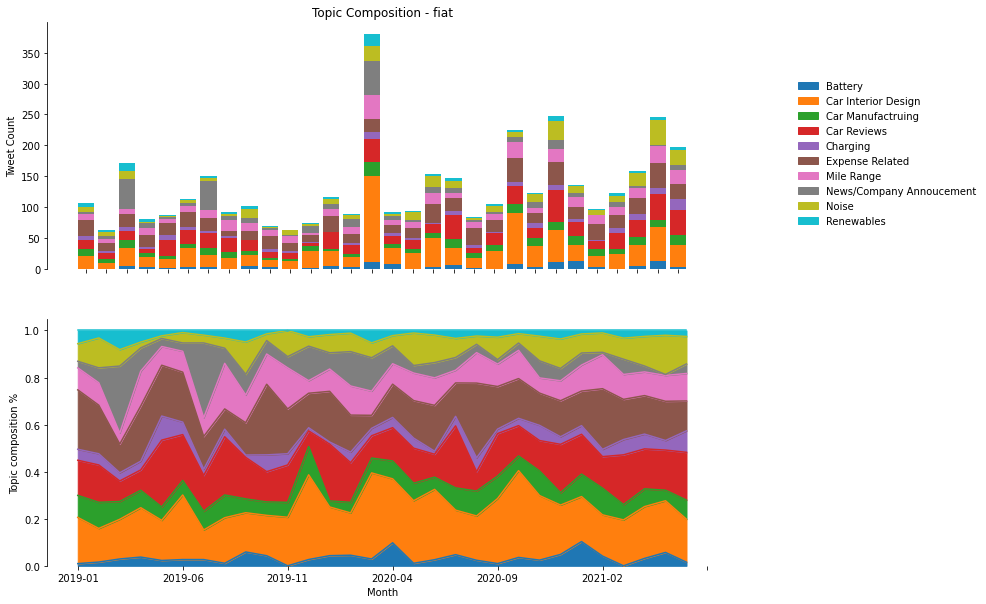

In [163]:
for brand in df.brand.unique():
    topic_plot(brand)

### general sentiment score plot

In [105]:
df.head()

,date,month_year,tweet,brand,clean_tweet,topic_n,prob,token,score,class,class_,topic
0,2019-01-17,2019-01,What a great start to a Thursday morning! Cong...,seat,what a great start to a thursday morning congr...,7,0.190452,"[great, start, thursday, morning, congratulati...",0.071265,7.0,positive,Noise
1,2019-01-29,2019-01,Someone else had been lucky in an @AutoExpress...,seat,someone else had been lucky in an competition ...,9,0.142857,"[lucky, competition, seatuk, seat, mii, seatmi...",0.059722,5.0,positive,Mile Range
2,2019-01-31,2019-01,We have the new #SEATMii available now with 0%...,seat,we have the new #seatmii available now with 0 ...,7,0.215336,"[new, seatmii, available, apr, representative,...",0.139158,15.0,positive,Noise
3,2019-02-22,2019-02,@SEATItalia @SEATofficial #seatmii #frline my ...,seat,#seatmii #frline my baby ♡,7,0.145083,"[seatmii, frline, baby, ♡]",0.016547,0.0,negative,Noise
4,2019-03-06,2019-03,Still searching for that perfect #firstcar? Wi...,seat,still searching for that perfect #firstcar wit...,7,0.211444,"[search, perfect, firstcar, ideal, mix, style,...",0.204137,16.0,positive,Noise


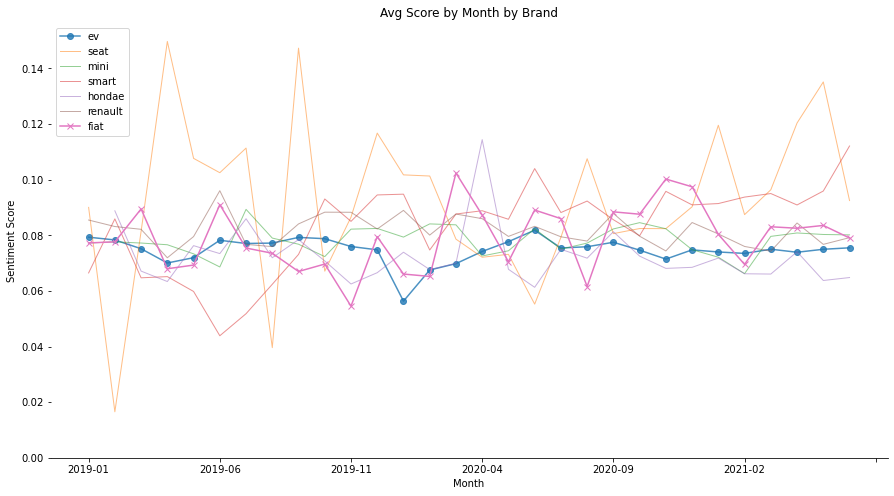

In [164]:
import matplotlib as mpl

fig,ax = plt.subplots(figsize = (15, 8))

tmp = df.groupby(['brand', 'month_year'])['score'].agg('mean').unstack()

valid_markers = mpl.markers.MarkerStyle.filled_markers
 
markers = np.random.choice(valid_markers, tmp3.shape[0], replace=False)

tmp3.xs('ev').plot(kind = 'line', ax = ax, marker = 'o', alpha = 0.8)

markers = ['+', '*', 's', 'o','v', 'p', '<', 'h','x', 'd']

l = ['seat', 'mini', 'smart', 'hondae', 'renault']
for i, brand in enumerate(l):
    tmp3.xs(brand).plot(kind = 'line', ax = ax, lw = 1, alpha = 0.5)

tmp3.xs('fiat').plot(kind = 'line', ax = ax, marker = 'x')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('data', 0))


ax.set_xlabel('Month')
ax.set_ylabel('Sentiment Score')

plt.title('Avg Score by Month by Brand')
plt.ylim(ymin=0)

plt.legend(loc='best')

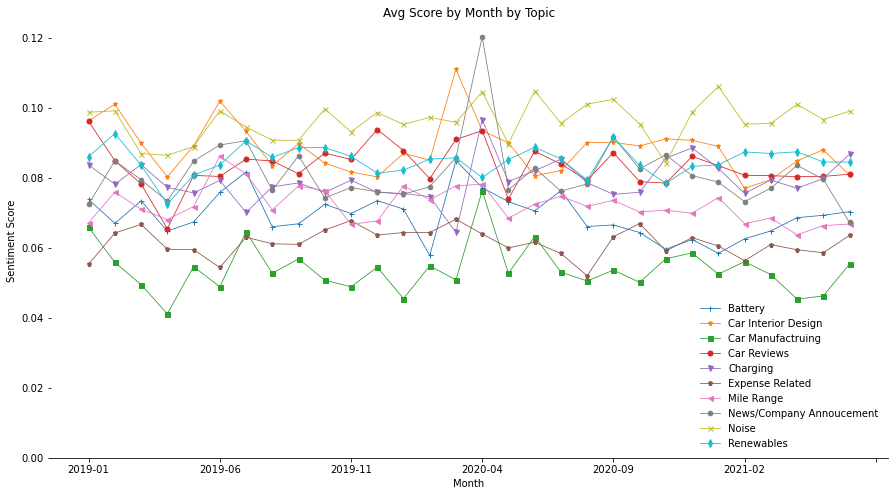

In [158]:
tmp = df.groupby(['topic', 'month_year'])['score'].agg('mean').unstack()
tmp

fig1,ax = plt.subplots(figsize = (15, 8))

tmp = df.groupby(['topic', 'month_year'])['score'].agg('mean').unstack()

markers = ['+', '*', 's', 'o','v', 'p', '<', 'h','x', 'd']

l = tmp.index
for i, brand in enumerate(l):
    tmp.xs(brand).plot(kind = 'line', ax = ax, lw = 0.8, marker = markers[i], markersize =5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('data', 0))


ax.set_xlabel('Month')
ax.set_ylabel('Sentiment Score')
plt.ylim(ymin=0)

plt.title('Avg Score by Month by Topic')
plt.legend(loc='best', frameon = False)

### sentiment by brand

In [135]:
df['date'] = pd.to_datetime(df['date'])

In [136]:
def plot_sent(brand):
    data = df[df['brand'] == brand]
    tmp = data.set_index('date').groupby('topic').resample('QS')['score'].agg('mean').unstack()

    fig, ax = plt.subplots(figsize = (10,6))

    for i, topic in enumerate(tmp.index):
        tmp.loc[topic, ].plot(ax = ax)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_position(('axes', 0)) 

    ax.set_xlabel('')
    ax.set_ylabel('Sentiment Score')


    plt.title('Avg Score by Quarter by topic by Brand: ' + brand)

    plt.legend(loc = 'best', bbox_to_anchor=(1.5 ,1), frameon = False)

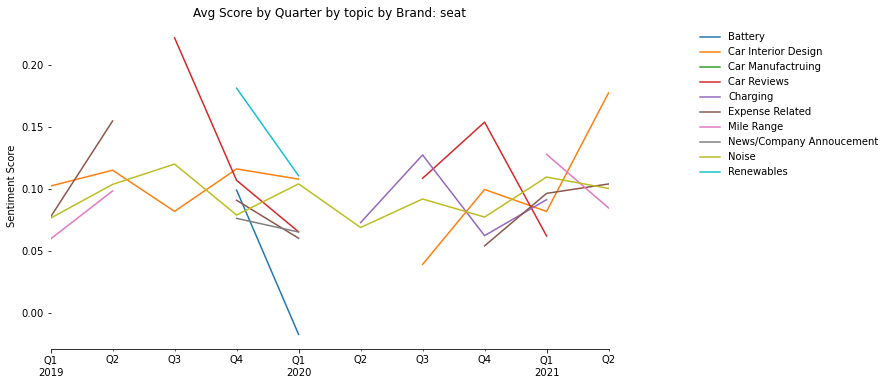

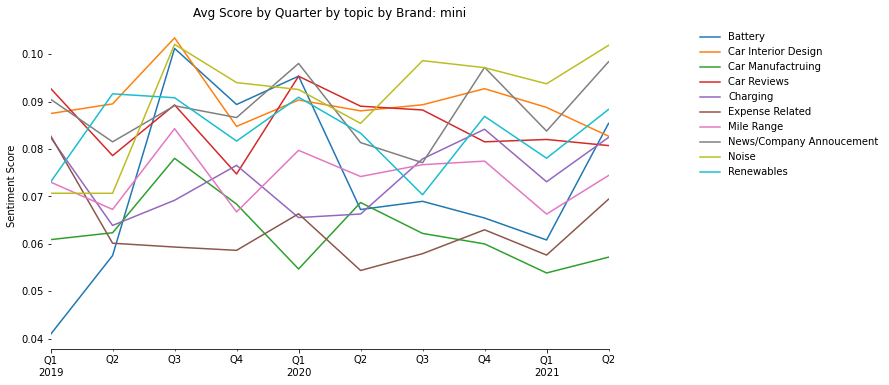

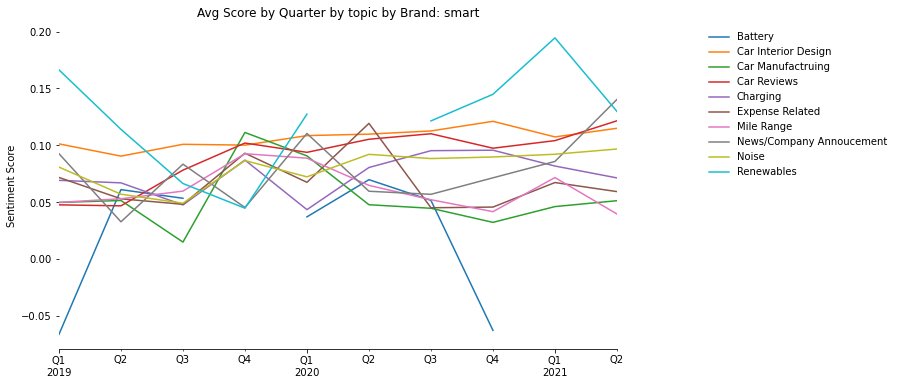

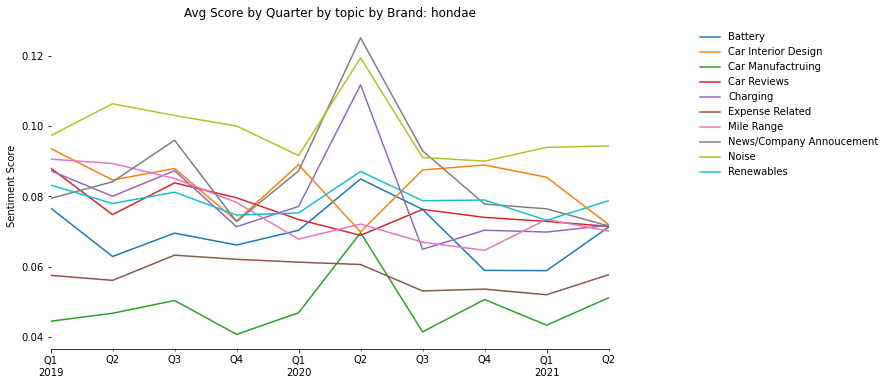

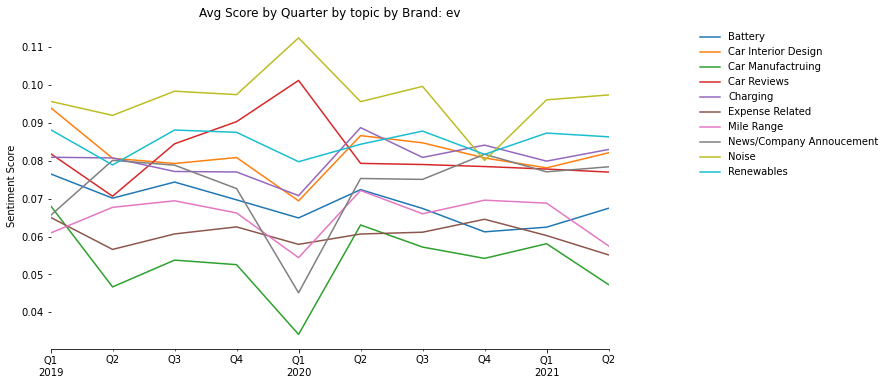

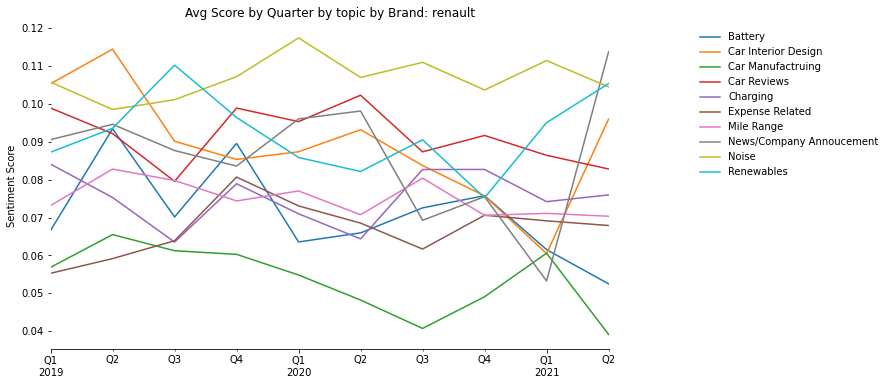

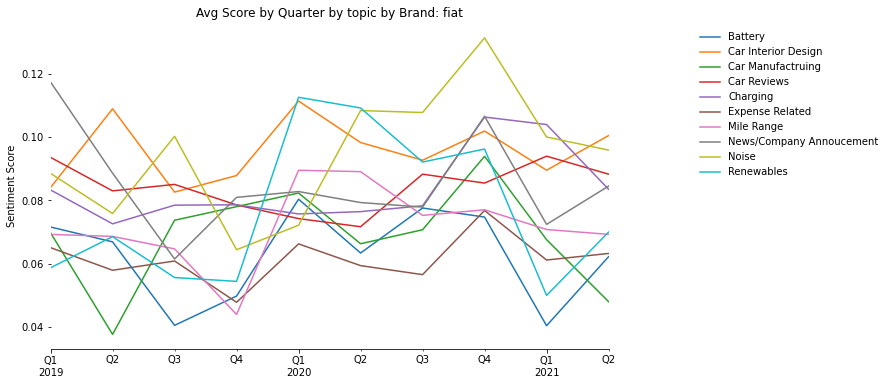

In [139]:
for brand in df.brand.unique():
    plot_sent(brand)

### sentiment change by brand by stage

In [87]:
df1 = df[df['date']>= '2019-10-01']

In [90]:
df1['stage'] = np.nan 

ipykernel_launcher:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [99]:
df1.loc[(df1['date']>= '2019-10-01') & (df1['date']< '2020-04-01'),'stage'] = 1
df1.loc[(df1['date']>= '2020-04-01') & (df1['date']< '2020-09-01'),'stage'] = 2
df1.loc[(df1['date']>= '2020-09-01') & (df1['date']< '2020-11-01'),'stage'] = 3
df1.loc[(df1['date']>= '2020-11-01') & (df1['date']< '2021-05-01'),'stage'] = 4
df1.loc[(df1['date']>= '2021-05-01') & (df1['date']< '2021-07-01'),'stage'] = 5

In [126]:
def sent_change(brand):

    tmp = df1[df1['brand'] == brand].groupby(['stage', 'topic'])['score'].agg('mean').unstack()

    fig, ax = plt.subplots(figsize = (10,6))

    for i, topic in enumerate(tmp.columns):
        plt.plot(tmp.index, tmp[topic], marker = 'o', markersize = 5, label = topic)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_position(('data', 0))

    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels(['Pre-Covid', '1st Round Lockdown', 'TBD', '2nd Round Lockdown', 'Post-Lockdown'])

    for i in tmp.index:
            ax.axvline(x = i, color = 'darkgray', ls = '--')

    plt.legend(loc = 'best', bbox_to_anchor=(1.5 ,1), frameon = False)
    plt.title('Sentiment Change - ' + brand)


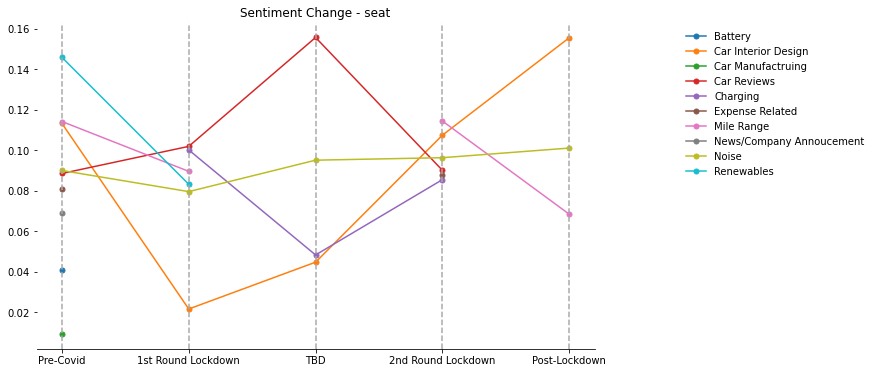

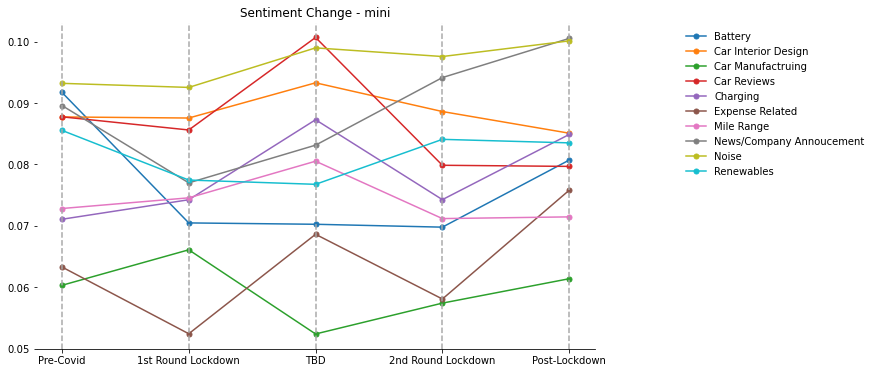

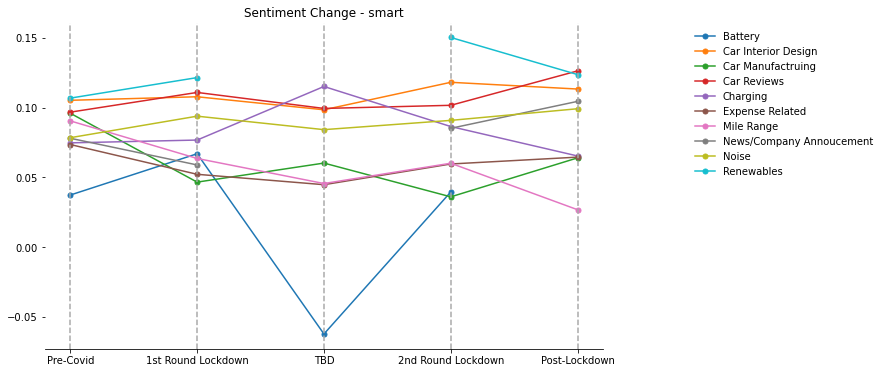

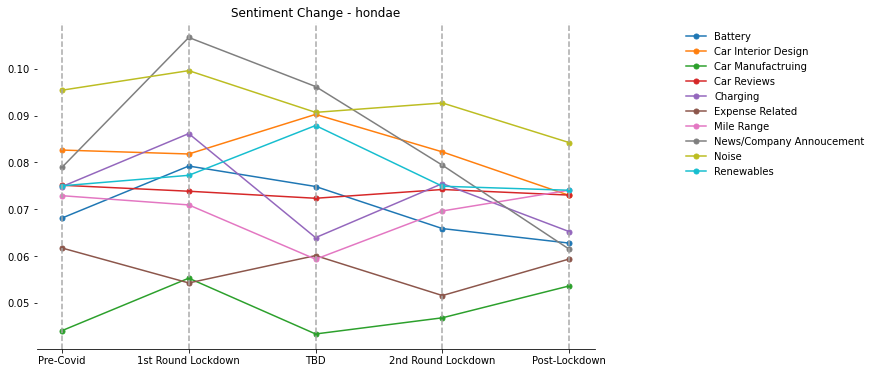

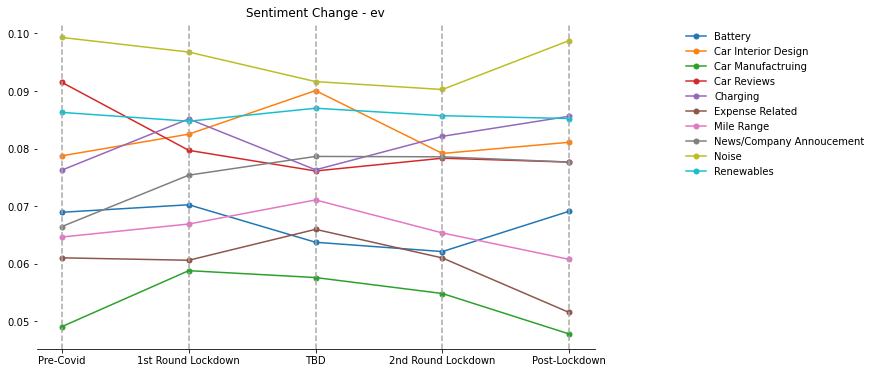

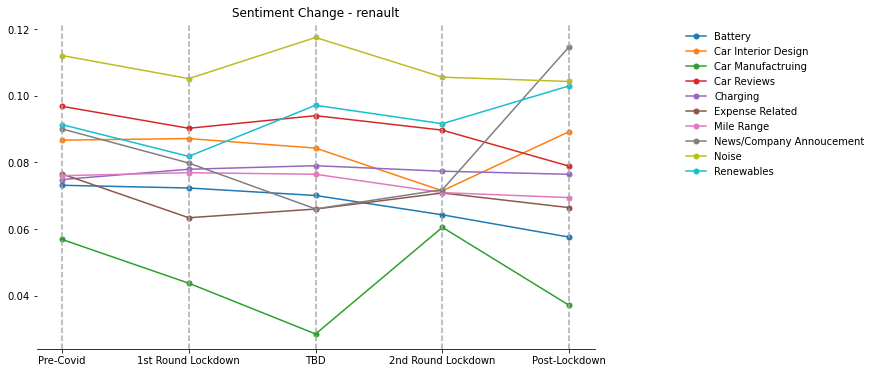

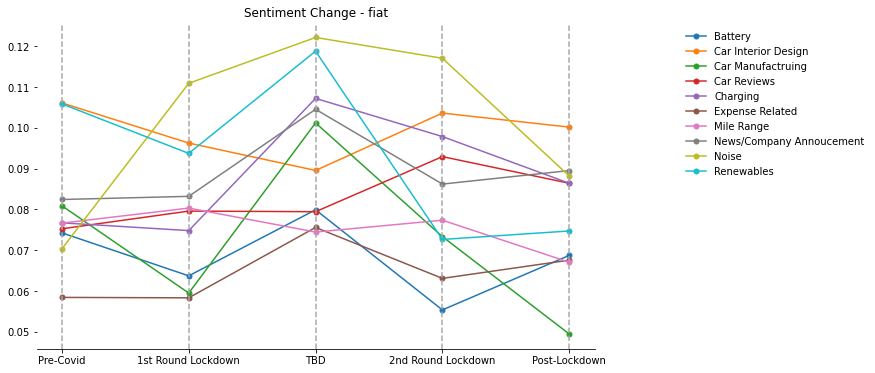

In [132]:
for brand in df1.brand.unique():
    sent_change(brand)